In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Data preprocessing

In [ ]:
df = pd.read_csv('state_LA.csv', header=0, low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173953 entries, 0 to 173952
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             173953 non-null  int64  
 1   lei                                       173953 non-null  object 
 2   derived_msa-md                            173953 non-null  int64  
 3   state_code                                173953 non-null  object 
 4   county_code                               169077 non-null  float64
 5   census_tract                              167380 non-null  float64
 6   conforming_loan_limit                     172785 non-null  object 
 7   derived_loan_product_type                 173953 non-null  object 
 8   derived_dwelling_category                 173953 non-null  object 
 9   derived_ethnicity                         173953 non-null  object 
 10  derived_race        

In [ ]:
selected_df = df[df['business_or_commercial_purpose'] == 2].copy()
selected_df = selected_df[(selected_df['action_taken'] == 1) | (selected_df['action_taken'] == 3)].copy()

In [ ]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103112 entries, 0 to 173952
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             103112 non-null  int64  
 1   lei                                       103112 non-null  object 
 2   derived_msa-md                            103112 non-null  int64  
 3   state_code                                103112 non-null  object 
 4   county_code                               99975 non-null   float64
 5   census_tract                              98807 non-null   float64
 6   conforming_loan_limit                     103107 non-null  object 
 7   derived_loan_product_type                 103112 non-null  object 
 8   derived_dwelling_category                 103112 non-null  object 
 9   derived_ethnicity                         103112 non-null  object 
 10  derived_race        

In [ ]:
#conditions

categorical = ['conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category', 'preapproval', 'loan_type', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'open-end_line_of_credit',
       'hoepa_status',
       'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features',
       'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units',
       'applicant_credit_score_type']

continuous = ['income', 'property_value', 'loan_amount', 'loan_to_value_ratio',
            'loan_term']

protected = ['derived_ethnicity', 'derived_race', 'derived_sex', 'applicant_age']       

target = [ 'action_taken']

denials = ['denial_reason-1']

all_cols = categorical + continuous + protected + target

In [ ]:
relevant_df = selected_df[selected_df.columns.intersection(all_cols)].copy()

In [ ]:
cleaned_df = relevant_df.dropna(axis=0).copy()

indexAge = cleaned_df[cleaned_df['loan_to_value_ratio'] == 'Exempt'].index
cleaned_df.drop(indexAge , inplace=True)

In [ ]:
arr_indices_top_drop = np.random.default_rng().choice(cleaned_df[cleaned_df['action_taken'] == 1].index, size=40000, replace=False)
cleaned_df.drop(index=arr_indices_top_drop, inplace=True)

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45017 entries, 0 to 173952
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   conforming_loan_limit                     45017 non-null  object 
 1   derived_loan_product_type                 45017 non-null  object 
 2   derived_dwelling_category                 45017 non-null  object 
 3   derived_ethnicity                         45017 non-null  object 
 4   derived_race                              45017 non-null  object 
 5   derived_sex                               45017 non-null  object 
 6   action_taken                              45017 non-null  int64  
 7   preapproval                               45017 non-null  int64  
 8   loan_type                                 45017 non-null  int64  
 9   loan_purpose                              45017 non-null  int64  
 10  lien_status                      

In [ ]:
cat_df = cleaned_df[cleaned_df.columns.intersection(categorical)]
cat_df = pd.get_dummies(cat_df, columns = categorical)

cont_df = cleaned_df[cleaned_df.columns.intersection(continuous)]

protected_df = cleaned_df[cleaned_df.columns.intersection(protected)]
protected_df = pd.get_dummies(protected_df, columns = protected)


#feature_df = pd.concat([cat_df, cont_df, protected_df], axis=1)
feature_df = pd.concat([cat_df, protected_df], axis=1)
#target_df = pd.get_dummies(cleaned_df[target], columns=target)
target_df = cleaned_df[target].copy()
target_df.replace(3,0, inplace=True)

In [ ]:
class_weights = [x / len(target_df) for x in list(target_df.value_counts())]
print(class_weights)
print([x for x in list(target_df.value_counts())])

[0.535419952462403, 0.4645800475375969]
[24103, 20914]


# Classifier

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [ ]:
def load_data(X, Y, test_size = 0.25):

  X = X.to_numpy(dtype='float32')
  Y = Y.to_numpy(dtype='float32')

  X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=test_size, shuffle=True)
  
  return X_train, X_test, y_train, y_test

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, target, data, transform=None, target_transform=None):
        self.target = target
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.target[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            target = self.target_transform(target)
        return data, target

In [ ]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()

         self.linear = torch.nn.Linear(input_dim, output_dim)

     def forward(self, x):
         
         #outputs = F.softmax(self.linear(x), dim=1)
         outputs = F.sigmoid(self.linear(x))
         
         return outputs

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, target, model, fn_type='utilitarian', _lambda=0, reg=0):

        #y_hat = torch.round(output)
        y_hat = F.sigmoid(5.0 * (output - 0.5))
        #y_hat = output

        #a = 1.0
        #b = -0.25
        #c = -0.5
        #d = 0.5

        a = -2.0
        b = 1.0
        c = 1.0
        d = 0.0

        alpha = 0.5
        epsilon = 0.001

        u_arr =  torch.add(a * y_hat * target, b * target) + c* y_hat + d + epsilon
        
        if fn_type == 'alpha_fairness':
          if alpha < 1:
            W = 1/(1-alpha) * torch.sum(torch.pow(u_arr, 1-alpha))
          elif alpha == 1:
            W = torch.sum(torch.log(u_arr))
      
        elif fn_type == 'proportional':
          W = torch.sum(torch.log(u_arr))

        elif fn_type == 'utilitarian':
          W = torch.sum(u_arr)

        elif fn_type == 'maximin':
          W = torch.min(u_arr)

        criterion = torch.nn.BCELoss(reduction='mean')
        l1_norm = torch.linalg.norm(model.linear.weight)

        loss = criterion(output, target) + reg * l1_norm - _lambda * W
        #loss = reg * l1_norm - _lambda * W
      
        return loss

In [ ]:
def get_loss(model, dataloader, _lambda, reg, fn_type):

    model.eval()
    device = next(model.parameters()).device
    loss = 0.0
    acc = 0.0
    total = 0.0
    criterion = CustomLoss()

    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            
            data = data.to(device)
            targets = targets.to(device)

            predicted = model(data).flatten()

            #u_arr = get_utilities(targets, predicted)
            #W = get_W(u_arr, fn_type=fn_type)

            #frac_loss = F.cross_entropy(predicted, targets)
            #frac_acc = (torch.argmax(predicted,1) == targets).sum() / len(targets)

            frac_loss = criterion(predicted, targets, model, fn_type, _lambda, reg)
            frac_acc = (torch.round(predicted) == targets).sum() / len(targets)

            loss += frac_loss
            acc += frac_acc

            total += 1

    return loss / total, acc / total

In [ ]:
def train(model, device, learning_rate, weight_decay, train_loader, test_loader, num_epochs=50, verbose=False, _lambda=0.0, fn_method=None):  

  #criterion = torch.nn.CrossEntropyLoss()
  #criterion = torch.nn.BCELoss()
  criterion = CustomLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  err_hist = {'train':[], 'test': []}

  for epoch in range(num_epochs):

      model = model.train()

      for i, (data, targets) in enumerate(train_loader):

          optimizer.zero_grad()

          data = data.to(device)
          targets = targets.to(device)

          predicted = model(data).flatten()

          #loss = criterion(predicted, targets) - _lambda * W

          loss = criterion(predicted, targets, model, fn_type=fn_method, _lambda=_lambda, reg=weight_decay)

          #optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      model.eval()
      err_hist['train'].append(get_loss(model, train_loader, _lambda, weight_decay, fn_method))
      err_hist['test'].append(get_loss(model, test_loader, _lambda, weight_decay, fn_method))

      if verbose:
        print('Epoch: %d | Train Loss: %.3f | Test Loss: %.3f | Train Accuracy: %.3f | Test Accuracy: %.3f' \
              %(epoch, err_hist['train'][-1][0], err_hist['test'][-1][0], err_hist['train'][-1][1], err_hist['test'][-1][1]))

  return model, err_hist

In [ ]:
def experiment(X_train, X_test, y_train, y_test, learning_rate=0.001, weight_decay=0.01, num_epochs=50, verbose=False, _lambda=0.0, fn_method='utilitarian'):
    # Use GPU if it is available.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Inpute Batch size:
    BATCH_SIZE = 128

    #Convert training data to a torch tensor
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train.flatten())
    #y_train = y_train.type(torch.LongTensor)

    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test.flatten())
    #y_test = y_test.type(torch.LongTensor)

    n_inputs = X_train.shape[1]
    n_outputs = 1

    print('Num inputs:', n_inputs)

    train_data = PredictionDataset(y_train, X_train)
    test_data = PredictionDataset(y_test, X_test)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    model = LogisticRegression(n_inputs, n_outputs)

    # Loading model into device
    model = model.to(device)

    model, err_hist = train(model, device, learning_rate, weight_decay, train_loader, test_loader, num_epochs=num_epochs, verbose=verbose, _lambda=_lambda, fn_method=fn_method)

    # Release the model from the GPU (else the memory wont hold up)
    model.cpu()

    return model, err_hist

# Experiments

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_df, target_df, test_size=0.25)

In [ ]:
model, _ = experiment(X_train, X_test, y_train, y_test, verbose=True, learning_rate=0.01, weight_decay=0.01, num_epochs=15, _lambda=1.0, fn_method='utilitarian')

Num inputs: 90
Epoch: 0 | Train Loss: -71.954 | Test Loss: -71.773 | Train Accuracy: 0.981 | Test Accuracy: 0.982
Epoch: 1 | Train Loss: -73.896 | Test Loss: -73.746 | Train Accuracy: 0.981 | Test Accuracy: 0.981
Epoch: 2 | Train Loss: -74.487 | Test Loss: -74.335 | Train Accuracy: 0.981 | Test Accuracy: 0.982
Epoch: 3 | Train Loss: -74.755 | Test Loss: -74.583 | Train Accuracy: 0.982 | Test Accuracy: 0.982
Epoch: 4 | Train Loss: -74.897 | Test Loss: -74.703 | Train Accuracy: 0.983 | Test Accuracy: 0.983
Epoch: 5 | Train Loss: -75.006 | Test Loss: -74.826 | Train Accuracy: 0.983 | Test Accuracy: 0.982
Epoch: 6 | Train Loss: -75.083 | Test Loss: -74.898 | Train Accuracy: 0.984 | Test Accuracy: 0.983
Epoch: 7 | Train Loss: -75.146 | Test Loss: -74.946 | Train Accuracy: 0.985 | Test Accuracy: 0.984
Epoch: 8 | Train Loss: -75.183 | Test Loss: -74.979 | Train Accuracy: 0.985 | Test Accuracy: 0.984
Epoch: 9 | Train Loss: -75.207 | Test Loss: -74.994 | Train Accuracy: 0.985 | Test Accuracy: 0

In [ ]:
def get_results_df(model, X_test, y_test, feature_df, protected_feature):

  #pred = torch.argmax(model(torch.from_numpy(X_test)),1)

  pred = np.round(model(torch.from_numpy(X_test)).detach().numpy()).flatten()
  true = y_test.flatten()

  if protected_feature == 'age':
    protected_attr_idx_1 = feature_df.columns.get_loc('applicant_age_25-34')
    protected_attr_idx_2 = feature_df.columns.get_loc('applicant_age_<25')
 
    t1 = X_test[:,protected_attr_idx_1]
    t2 = X_test[:,protected_attr_idx_2]

    X = np.logical_or(t1, t2).astype(float)

    results_df = pd.DataFrame([pred, true, X.T], index=['Predicted', 'True', 'Protected Attribute']).T
  
  elif protected_feature == 'race':
    
    protected_attr_idx = feature_df.columns.get_loc('derived_race_White')

    X = np.logical_not(X_test[:,protected_attr_idx]).astype(float)

    results_df = pd.DataFrame([pred, true, X.T], index=['Predicted', 'True', 'Protected Attribute']).T

  else:
    protected_attr_idx = feature_df.columns.get_loc(protected_feature)

    results_df = pd.DataFrame([pred, true, X_test[:,protected_attr_idx].T], index=['Predicted', 'True', 'Protected Attribute']).T

  return results_df

In [ ]:
results_df = get_results_df(model, X_test, y_test, feature_df, 'race')
results_df_1 = get_results_df(model_1, X_test, y_test, feature_df, 'race')

In [ ]:
def demographic_parity(results_df):

  num_positive_prot = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['Predicted'] == 1)])
  num_positive = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['Predicted'] == 1)])

  num_protected = len(results_df[results_df['Protected Attribute'] == 1])
  num_unprotected = len(results_df[results_df['Protected Attribute'] == 0])

  frac_misclassified_prot = num_positive_prot / num_protected
  frac_misclassified = num_positive / num_unprotected

  print('Fraction positive protected: {:.2%}'.format(frac_misclassified_prot))
  print('Fraction positive: {:.2%}'.format(frac_misclassified))

  return frac_misclassified, frac_misclassified_prot


def equality_opportunity(results_df):

  num_positive_prot = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['Predicted'] == 1) & (results_df['True'] == 1)])
  num_positive = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['Predicted'] == 1) & (results_df['True'] == 1)])

  num_protected = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['True'] == 1)])
  num_unprotected = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['True'] == 1)])

  frac_misclassified_prot = num_positive_prot / num_protected
  frac_misclassified = num_positive / num_unprotected

  print('Fraction positive protected: {:.2%}'.format(frac_misclassified_prot))
  print('Fraction positive: {:.2%}'.format(frac_misclassified))

  return frac_misclassified, frac_misclassified_prot


def get_confusion_matrix_by_protected_attr(results_df):

  num_TP_prot = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['Predicted'] == 1) & (results_df['True'] == 1)])
  num_FP_prot = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['Predicted'] == 1) & (results_df['True'] == 0)])
  num_TN_prot = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['Predicted'] == 0) & (results_df['True'] == 0)])
  num_FN_prot = len(results_df[(results_df['Protected Attribute'] == 1) & (results_df['Predicted'] == 0) & (results_df['True'] == 1)])

  num_prot = len(results_df[(results_df['Protected Attribute'] == 1)])

  num_TP = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['Predicted'] == 1) & (results_df['True'] == 1)])
  num_FP = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['Predicted'] == 1) & (results_df['True'] == 0)])
  num_TN = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['Predicted'] == 0) & (results_df['True'] == 0)])
  num_FN = len(results_df[(results_df['Protected Attribute'] == 0) & (results_df['Predicted'] == 0) & (results_df['True'] == 1)])

  num_not_prot = len(results_df[(results_df['Protected Attribute'] == 0)])

  print("Protected class")
  print("TP: {:.2%}".format(num_TP_prot / num_prot))
  print("FP: {:.2%}".format(num_FP_prot / num_prot))
  print("TN: {:.2%}".format(num_TN_prot / num_prot))
  print("FN: {:.2%}".format(num_FN_prot / num_prot))

  print("\nNot Protected class")
  print("TP: {:.2%}".format(num_TP / num_not_prot))
  print("FP: {:.2%}".format(num_FP / num_not_prot))
  print("TN: {:.2%}".format(num_TN / num_not_prot))
  print("FN: {:.2%}".format(num_FN / num_not_prot))



In [ ]:
demographic_parity(results_df)

Fraction positive protected: 85.87%
Fraction positive: 68.27%


(0.6826801517067004, 0.8587005906406179)

In [ ]:
equality_opportunity(results_df)

Fraction positive protected: 98.89%
Fraction positive: 97.64%


(0.9764492753623188, 0.9889473684210527)

In [ ]:
get_confusion_matrix_by_protected_attr(results_df)

Protected class
TP: 48.63%
FP: 0.91%
TN: 49.09%
FN: 1.37%

Not Protected class
TP: 70.30%
FP: 0.66%
TN: 27.61%
FN: 1.42%


## Full Experiment

In [ ]:
def run_full_experiment():

  lambdas = [0, 0.01, 0.1, 1, 10, 100]
  w_types = ['alpha_fairness', 'proportional', 'utilitarian', 'maximin']
  protected_attr = ['age', 'race']

  total_iters = len(lambdas) * len(w_types) * len(protected_attr)
  i = 1

  fin_results = []

  for attr in protected_attr:

    for w in w_types:

      for lambda_ in lambdas:

        print("Iteration {} of {}".format(i, total_iters))

        model, scores = experiment(X_train, X_test, y_train, y_test, verbose=False, learning_rate=0.01, weight_decay=0.01, num_epochs=10, _lambda=lambda_, fn_method=w)
      
        accuracy = float(scores['test'][-1][1].numpy())
        
        results = get_results_df(model, X_test, y_test, feature_df, attr)

        pos_rate, pos_rate_prot = demographic_parity(results)
        true_pos_rate, true_pos_rate_prot  = equality_opportunity(results)
        
        result = (attr, w, lambda_, accuracy, pos_rate, pos_rate_prot, true_pos_rate, true_pos_rate_prot)

        fin_results.append(result)
        i += 1
  
  return fin_results

In [ ]:
results = run_full_experiment()

Iteration 1 of 48
Num inputs: 90
Fraction positive protected: 66.79%
Fraction positive: 47.69%
Fraction positive protected: 98.56%
Fraction positive: 97.20%
Iteration 2 of 48
Num inputs: 90
Fraction positive protected: 33.73%
Fraction positive: 53.40%
Fraction positive protected: 1.88%
Fraction positive: 4.35%
Iteration 3 of 48
Num inputs: 90
Fraction positive protected: 33.66%
Fraction positive: 53.33%
Fraction positive protected: 1.77%
Fraction positive: 4.21%
Iteration 4 of 48
Num inputs: 90
Fraction positive protected: 33.55%
Fraction positive: 52.38%
Fraction positive protected: 1.72%
Fraction positive: 2.87%
Iteration 5 of 48
Num inputs: 90
Fraction positive protected: 33.21%
Fraction positive: 52.19%
Fraction positive protected: 1.44%
Fraction positive: 2.65%
Iteration 6 of 48
Num inputs: 90
Fraction positive protected: 33.25%
Fraction positive: 52.24%
Fraction positive protected: 1.50%
Fraction positive: 2.65%
Iteration 7 of 48
Num inputs: 90
Fraction positive protected: 66.64%

In [ ]:
results_df = pd.DataFrame(results, columns=["attribute", "W_function", "lambda", "accuracy", "pos_rate", "pos_rate_prot", "true_pos_rate", "true_pos_rate_prot"])

In [ ]:
results_df

,attribute,W_function,lambda,accuracy,pos_rate,pos_rate_prot,true_pos_rate,true_pos_rate_prot
0,age,alpha_fairness,0.00,0.983125,0.471692,0.664545,0.965328,0.982816
1,age,alpha_fairness,0.01,0.983836,0.477866,0.667915,0.972501,0.985588
2,age,alpha_fairness,0.10,0.983125,0.471459,0.663796,0.964849,0.982816
3,age,alpha_fairness,1.00,0.982770,0.470294,0.663796,0.963176,0.982816
4,age,alpha_fairness,10.00,0.982326,0.468779,0.663796,0.961023,0.982816
5,age,alpha_fairness,100.00,0.984102,0.474953,0.664920,0.969871,0.983370
6,age,proportional,0.00,0.981084,0.466216,0.663048,0.956958,0.981707
7,age,proportional,0.01,0.982948,0.473788,0.664545,0.967241,0.982816
8,age,proportional,0.10,0.981616,0.466799,0.663422,0.958154,0.982262
9,age,proportional,1.00,0.982593,0.470294,0.663796,0.962936,0.982816


In [ ]:
def plot_bar_chart(ax, results_df, _lambda=0.1, attribute='age', true_pos=False):

  lambda_1_df = results_df[((results_df['attribute'] == attribute) & (results_df['lambda'] == _lambda)) | ((results_df['W_function'] == 'utilitarian') & (results_df['attribute'] == attribute) & (results_df['lambda'] == 0.0))].copy()
  lambda_1_df = lambda_1_df.reset_index(drop=True)
  lambda_1_df = lambda_1_df.drop(['attribute'], axis=1)
  lambda_1_df.loc[2,'W_function'] = 'standard'
  lambda_1_df = lambda_1_df.drop(['lambda'], axis=1)
  lambda_1_df.set_index(lambda_1_df['W_function'], inplace=True)

  lambda_1_df.index = ['Alpha Fairness', 'Prop. Fairness', 'Standard LR', 'Utilitarian', 'Maximin']

  lambda_1_df = lambda_1_df.reindex(['Standard LR', 'Utilitarian', 'Alpha Fairness', 'Prop. Fairness', 'Maximin'])
  
  if attribute == 'age':
    if true_pos:
      lambda_1_df = lambda_1_df[['true_pos_rate', 'true_pos_rate_prot']].copy()
      lambda_1_df = lambda_1_df.rename({'true_pos_rate': 'Old', 'true_pos_rate_prot': 'Young'}, axis=1)
      title = "True Positive rate, Lambda = {}".format(_lambda)
    else:
      lambda_1_df = lambda_1_df[['pos_rate', 'pos_rate_prot']].copy()
      lambda_1_df = lambda_1_df.rename({'pos_rate': 'Old', 'pos_rate_prot': 'Young'}, axis=1)
      title = "Positive classification rate, Lambda = {}".format(_lambda)
    
    ax = lambda_1_df[['Old', 'Young']].plot.bar(ax=ax)
    
  else: 
    if true_pos:
      lambda_1_df = lambda_1_df[['true_pos_rate', 'true_pos_rate_prot']].copy()
      lambda_1_df = lambda_1_df.rename({'true_pos_rate': 'White', 'true_pos_rate_prot': 'Non-White'}, axis=1)
      title = "True Positive rate, Lambda = {}".format(_lambda)
    else:
      lambda_1_df = lambda_1_df[['pos_rate', 'pos_rate_prot']].copy()
      lambda_1_df = lambda_1_df.rename({'pos_rate': 'White', 'pos_rate_prot': 'Non-White'}, axis=1)
      title = "Positive classification rate, Lambda = {}".format(_lambda)
    
    ax = lambda_1_df[['White', 'Non-White']].plot.bar(ax=ax)
  
  ax.set_title(title)
  ax.legend(loc='lower right')

  for container in ax.containers:
    ax.bar_label(container, fmt='{:.2f}', fontsize=7)

  return ax

In [ ]:
def plot_all(results_df, attribute='age'):
  fig, axes= plt.subplots(figsize=(10, 8), nrows=2, ncols=2)

  lambdas = [0.1, 1.0]
  vals = [True, False]

  for i in range(2):

    _lambda = lambdas[i]
    for j in range(2):

      true_val = vals[j]

      ax = plot_bar_chart(axes[i,j], results_df, _lambda=_lambda, attribute=attribute, true_pos=true_val)

  fig.tight_layout() 
  plt.show()


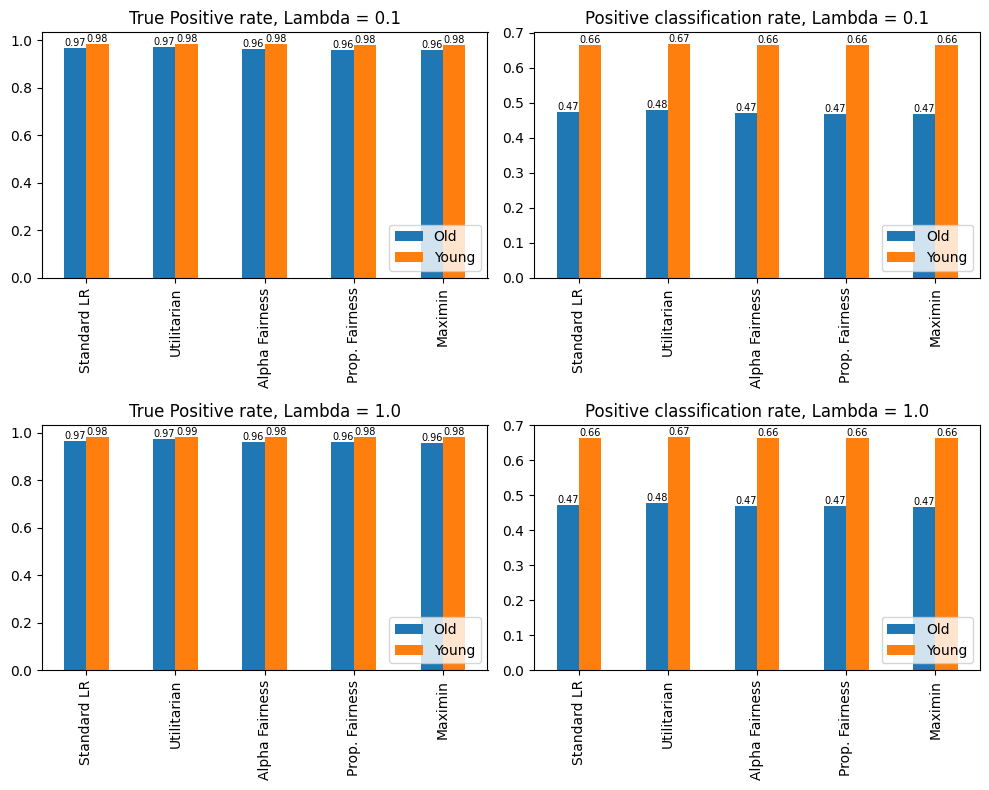

In [ ]:
plot_all(results_df, 'age')

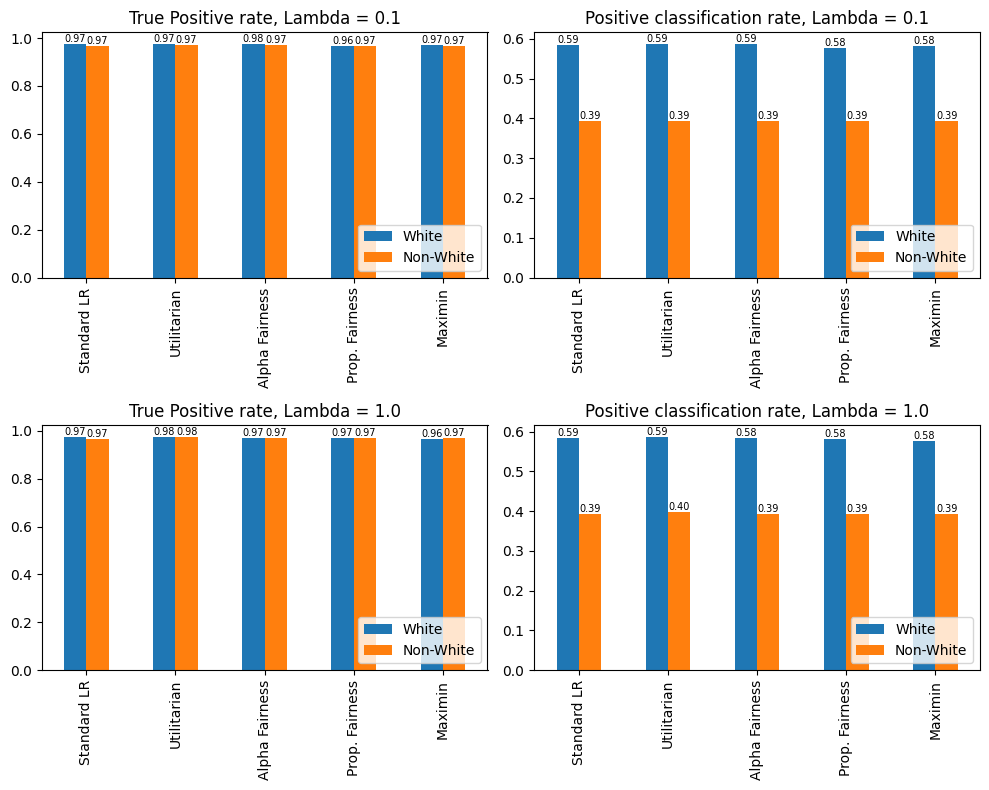

In [ ]:
plot_all(results_df, 'race')

In [ ]:
def plot_accuracy(df, attribute='age'):
  t = df[df['attribute'] == attribute][['W_function', 'lambda', 'accuracy']].copy().pivot(columns='W_function', index='lambda', values='accuracy')

  t = t.T

  t.index = ['Alpha Fairness', 'Maximin', 'Prop. Fairness', 'Utilitarian']

  t = t.T

  t.index = t.index.astype(str)

  ax = t.plot()
  #ax.set_ylim(0.975,0.985)
  #plt.title("Accuracy for increasing lambda with {} data".format(attribute))
  plt.ylabel('Accuracy')
  plt.show()



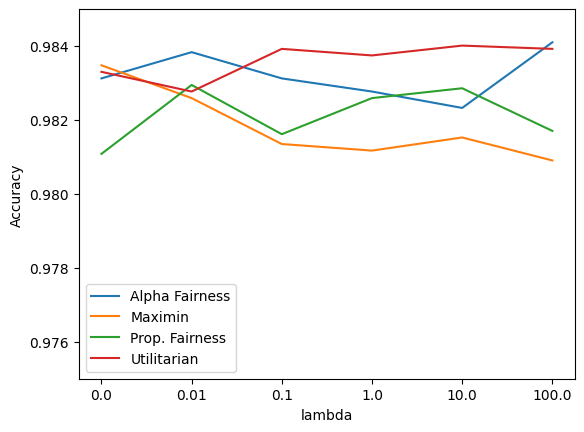

In [ ]:
plot_accuracy(results_df, 'age')

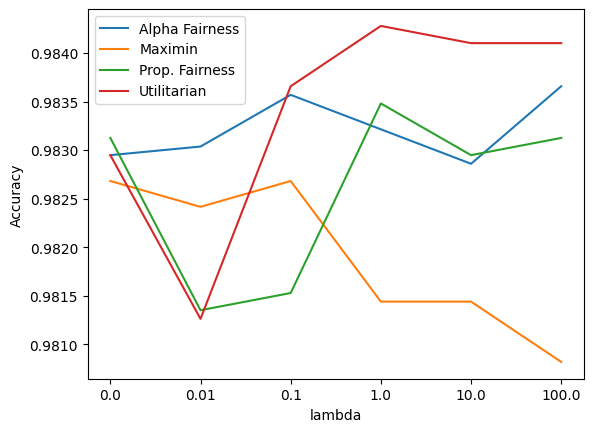

In [ ]:
plot_accuracy(results_df, 'race')

In [ ]:
results_incorrect_df = pd.DataFrame(results, columns=["attribute", "W_function", "lambda", "accuracy", "pos_rate", "pos_rate_prot", "true_pos_rate", "true_pos_rate_prot"])
results_incorrect_df

,attribute,W_function,lambda,accuracy,pos_rate,pos_rate_prot,true_pos_rate,true_pos_rate_prot
0,age,alpha_fairness,0.00,0.984191,0.476934,0.667915,0.972023,0.985588
1,age,alpha_fairness,0.01,0.019183,0.534017,0.337327,0.043520,0.018847
2,age,alpha_fairness,0.10,0.018473,0.533318,0.336578,0.042085,0.017738
3,age,alpha_fairness,1.00,0.015898,0.523765,0.335455,0.028694,0.017184
4,age,alpha_fairness,10.00,0.015632,0.521901,0.332085,0.026542,0.014412
5,age,alpha_fairness,100.00,0.015365,0.522367,0.332460,0.026542,0.014967
6,age,proportional,0.00,0.983481,0.475536,0.666417,0.969871,0.983925
7,age,proportional,0.01,0.018828,0.533551,0.337327,0.042563,0.018847
8,age,proportional,0.10,0.018473,0.533318,0.336578,0.042085,0.017738
9,age,proportional,1.00,0.016519,0.527260,0.335829,0.033238,0.017184


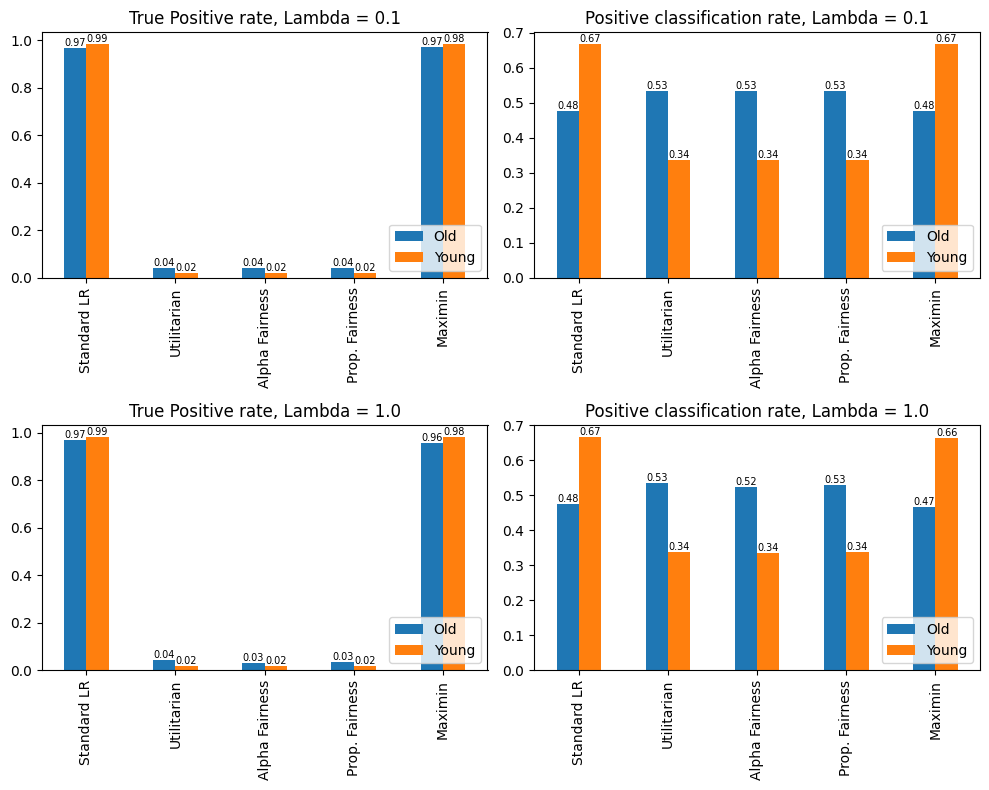

In [ ]:
plot_all(results_incorrect_df, 'age')

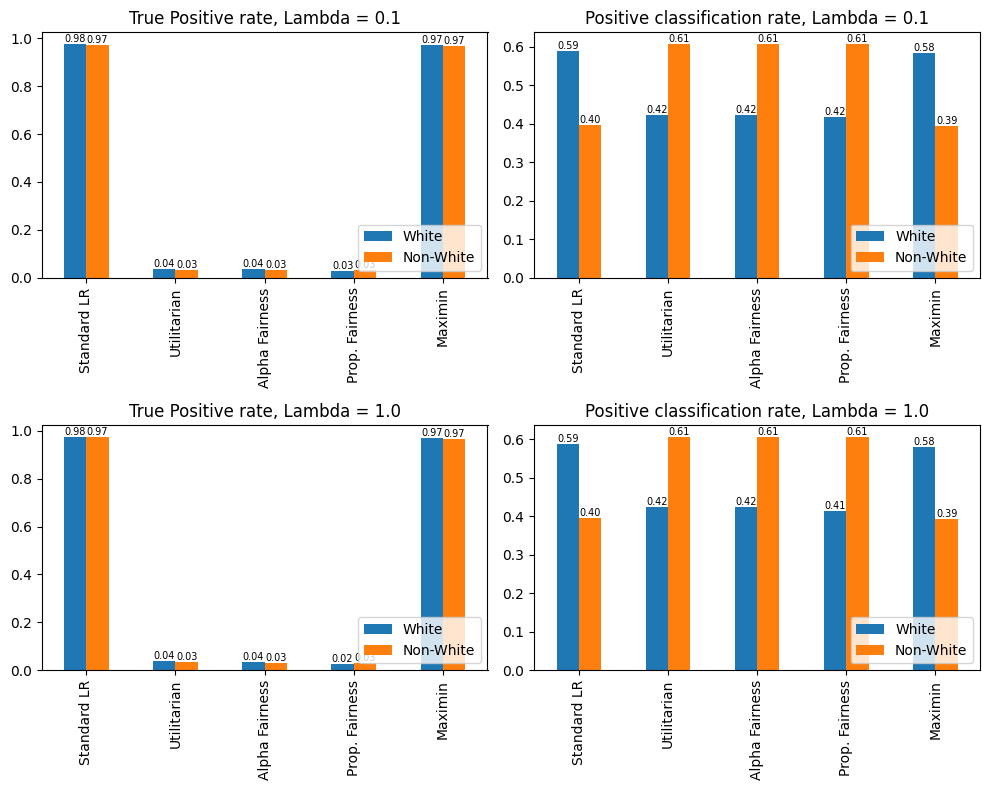

In [ ]:
plot_all(results_incorrect_df, 'race')

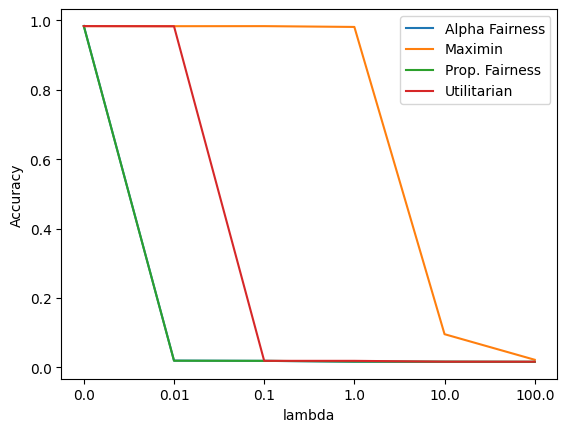

In [ ]:
plot_accuracy(results_incorrect_df, 'age')

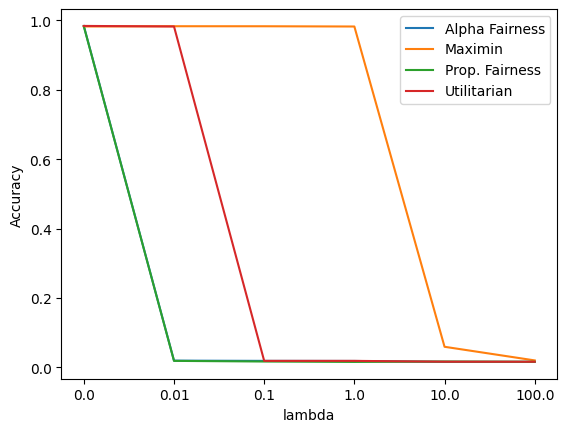

In [ ]:
plot_accuracy(results_incorrect_df, 'race')

# Utils

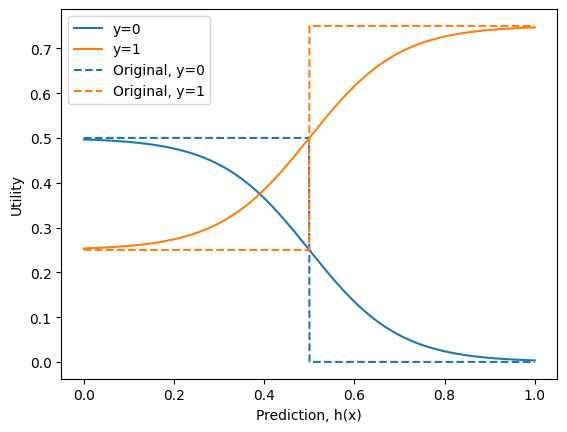

In [ ]:
def plot_utils():

  x = np.linspace(0,1, 1000)

  y_hat = 1 / (1 + np.exp(-10 * (x - 0.5)))

  target = 0

  a = 1.0
  b = -0.25
  c = -0.5
  d = 0.5

  u_arr_0 =  np.add(a * y_hat * 0, b * 0) + c* y_hat + d
  u_arr_1 =  np.add(a * y_hat * 1, b * 1) + c* y_hat + d

  u_orig_1 = 0.5 * np.heaviside(x-0.5, 0.25) + 0.25
  u_orig_0 = -0.5 * np.heaviside(x-0.5, 0.5) + 0.5

  plt.plot(x, u_arr_0, label='y=0')
  plt.plot(x, u_arr_1, label='y=1')
  plt.plot(x, u_orig_0, color='tab:blue', linestyle='dashed', label='Original, y=0')
  plt.plot(x, u_orig_1, color='tab:orange', linestyle='dashed', label='Original, y=1')

  plt.xlabel("Prediction, h(x)")
  plt.ylabel("Utility")
  plt.legend()

  plt.show()

plot_utils()